In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
import sklearn
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')

In [2]:
images = glob('train_cancer/*/*.jpg')
len(images)

2637

In [3]:
#replace backslash with forward slash to avoid unexpected errors
images = [path.replace('\\', '/') for path in images]
df = pd.DataFrame({'filepath': images})
df['label'] = df['filepath'].str.split('/', expand=True)[1]
df.head()

,filepath,label
0,train_cancer/benign/100.jpg,benign
1,train_cancer/benign/1000.jpg,benign
2,train_cancer/benign/1001.jpg,benign
3,train_cancer/benign/1002.jpg,benign
4,train_cancer/benign/1004.jpg,benign


In [4]:
df['label_bin'] = np.where(df['label'].values == 'malignant', 1, 0)
df.head()

,filepath,label,label_bin
0,train_cancer/benign/100.jpg,benign,0
1,train_cancer/benign/1000.jpg,benign,0
2,train_cancer/benign/1001.jpg,benign,0
3,train_cancer/benign/1002.jpg,benign,0
4,train_cancer/benign/1004.jpg,benign,0


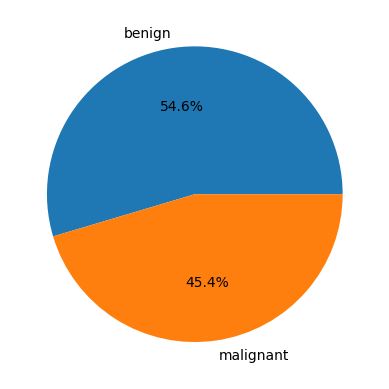

In [5]:
x = df['label'].value_counts()
plt.pie(x.values,
		labels=x.index,
		autopct='%1.1f%%')
plt.show()

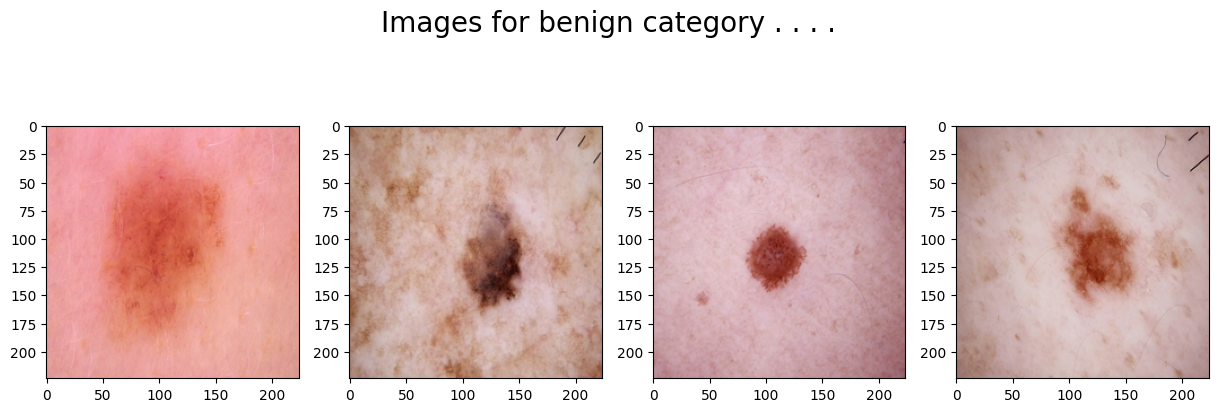

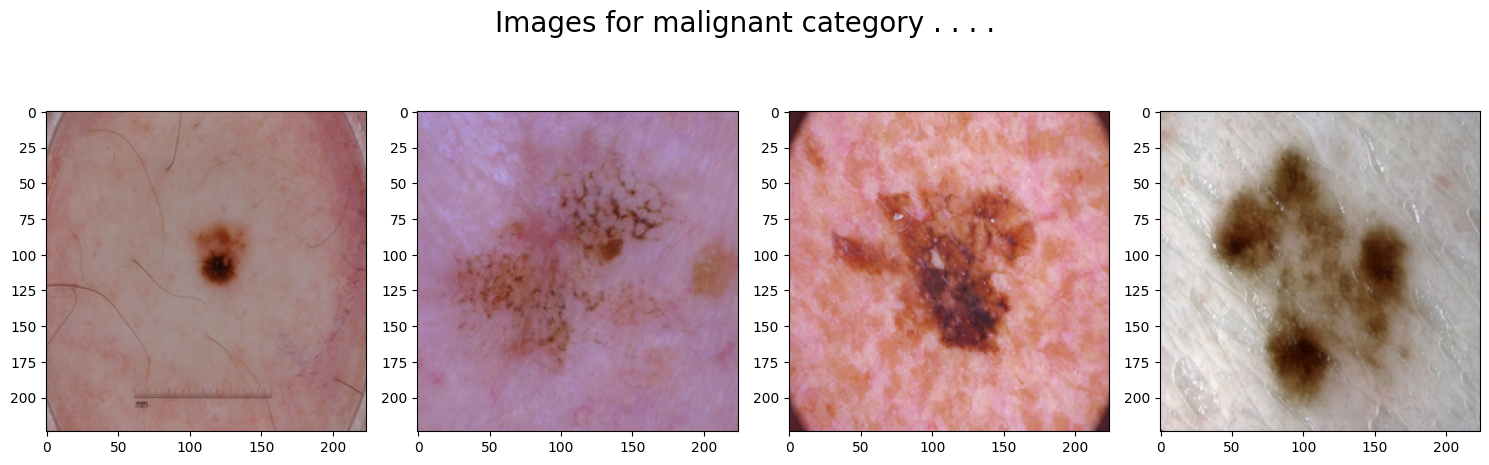

In [6]:
for cat in df['label'].unique():
	temp = df[df['label'] == cat]

	index_list = temp.index
	fig, ax = plt.subplots(1, 4, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
	for i in range(4):
		index = np.random.randint(0, len(index_list))
		index = index_list[index]
		data = df.iloc[index]

		image_path = data[0]

		img = np.array(Image.open(image_path))
		ax[i].imshow(img)
plt.tight_layout()
plt.show()

In [29]:
features = df['filepath']
target = df['label_bin']

X_train, X_val,	Y_train, Y_val = train_test_split(features, target,
									test_size=0.40,
									random_state=10)

X_train.shape, X_val.shape

((1582,), (1055,))

In [30]:
def decode_image(filepath, label=None):

	img = tf.io.read_file(filepath)
	img = tf.image.decode_jpeg(img)
	img = tf.image.resize(img, [224, 224])
	img = tf.cast(img, tf.float32) / 255.0

	if label == 0:
		Label = 0
	else:
		Label = 1

	return img, Label

In [31]:
train_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_train, Y_train))
	.map(decode_image, num_parallel_calls=AUTO)
	.batch(32)
	.prefetch(AUTO)
)

val_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_val, Y_val))
	.map(decode_image, num_parallel_calls=AUTO)
	.batch(32)
	.prefetch(AUTO)
)
print(X_train.shape)  # Debería ser (num_imagenes, alto, ancho, canales)
print(X_val.shape)    # Debería ser (num_imagenes, alto, ancho, canales)

(1582,)
(1055,)


In [32]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

pre_trained_model = EfficientNetB7(
	input_shape=(224, 224, 3),
	weights='imagenet',
	include_top=False
)

for layer in pre_trained_model.layers:
	layer.trainable = False

In [33]:
from tensorflow.keras import Model

inputs = layers.Input(shape=(224, 224, 3))
x = pre_trained_model(inputs)

x = layers.GlobalAveragePooling2D()(x)  # Usamos GlobalAveragePooling2D en lugar de Flatten
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

In [22]:
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb7 (Functional)          │ (None, 7, 7, 2560)          │      64,097,687 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2560)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,821,400 (247.27 MB)

 Trainable params: 722,689 (2.76 MB)

 Non-trainable params: 64,098,711 (244.52 MB)

None


In [34]:
model.compile(
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
	optimizer='adam',
	metrics=['AUC']
)

In [35]:
history = model.fit(train_ds,
					validation_data=val_ds,
					epochs=5,
					verbose=1)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 429s 8s/step - AUC: 0.4751 - loss: 0.8762 - val_AUC: 0.5021 - val_loss: 1.0690
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 384s 8s/step - AUC: 0.4920 - loss: 0.8006 - val_AUC: 0.4963 - val_loss: 0.9496
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 384s 8s/step - AUC: 0.4820 - loss: 0.7954 - val_AUC: 0.4966 - val_loss: 0.7010
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 385s 8s/step - AUC: 0.4847 - loss: 0.7763 - val_AUC: 0.4960 - val_loss: 0.7818
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 384s 8s/step - AUC: 0.5226 - loss: 0.7484 - val_AUC: 0.6359 - val_loss: 0.6984


In [25]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,AUC,loss,val_AUC,val_loss
0,0.511858,0.799912,0.508065,0.737720
1,0.495503,0.775194,0.495507,0.692750
2,0.486924,0.757731,0.533900,0.693738
3,0.503538,0.748535,0.621947,0.706251
4,0.518279,0.738557,0.551613,0.711808


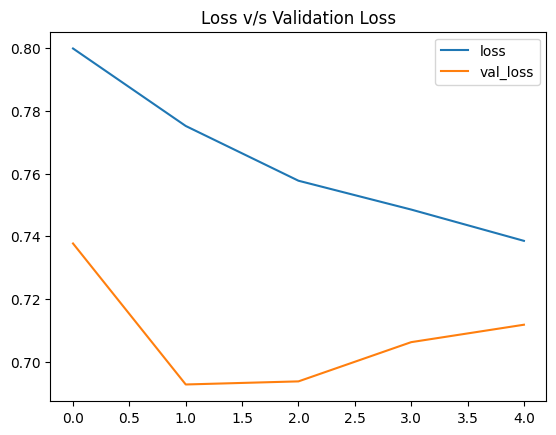

In [26]:
hist_df['loss'].plot()
hist_df['val_loss'].plot()
plt.title('Loss v/s Validation Loss')
plt.legend()
plt.show()

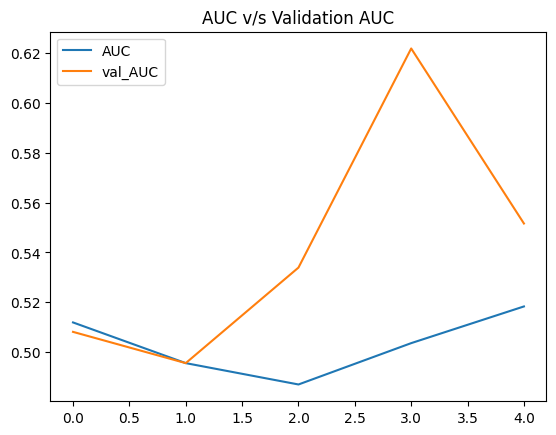

In [27]:
hist_df['AUC'].plot()
hist_df['val_AUC'].plot()
plt.title('AUC v/s Validation AUC')
plt.legend()
plt.show()

In [36]:
# Guardar el modelo en formato H5
model.save('modelo_entrenado.h5')